In [1]:

import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

np.set_printoptions(threshold=2**31-1)


# ------------------Functions------------------#

def showimages():
    cv2.namedWindow('Source Image', cv2.WINDOW_AUTOSIZE)
    # cv2.namedWindow('Threshold Image', cv2.WINDOW_AUTOSIZE)
    # cv2.namedWindow('Binary Image', cv2.WINDOW_AUTOSIZE)
    # cv2.namedWindow('Contour Image', cv2.WINDOW_NORMAL)
    # cv2.namedWindow('noise_remove Image', cv2.WINDOW_NORMAL)

    cv2.imshow("Source Image", src_img)
    # cv2.imshow("Binary Image", bin_img)
    # cv2.imshow("Threshold Image", final_thr)


# cv2.imshow("Contour Image", final_contr)
# cv2.imshow('noise_remove Image', noise_remove)

# plt.show()


def closewindows():
    k = cv2.waitKey(0)
    if k & 0xFF == ord('s'):
        comment = input("Comment:-\n ")
        cv2.imwrite('./data/test_result/' + comment + '_thres' + '.jpg', final_thr)
        cv2.imwrite('./data/test_result/' + comment + '_src' + '.jpg', src_img)
        cv2.imwrite('./data/test_result/' + comment + '_contr' + '.jpg', final_contr)
        print("Completed")
    elif k & 0xFF == int(27):
        cv2.destroyAllWindows()
    else:
        closewindows()


def line_array(array):
    list_x_upper = []
    list_x_lower = []
    for y in range(5, len(array) - 5):
        s_a, s_p = strtline(y, array)
        e_a, e_p = endline(y, array)
        if s_a >= 7 and s_p >= 5:
            list_x_upper.append(y)
        # bin_img[y][:] = 255
        if e_a >= 5 and e_p >= 7:
            list_x_lower.append(y)
        # bin_img[y][:] = 255
    return list_x_upper, list_x_lower


def strtline(y, array):
    count_ahead = 0
    count_prev = 0
    for i in array[y:y + 10]:
        if i > 3:
            count_ahead += 1
    for i in array[y - 10:y]:
        if i == 0:
            count_prev += 1
    return count_ahead, count_prev


def endline(y, array):
    count_ahead = 0
    count_prev = 0
    for i in array[y:y + 10]:
        if i == 0:
            count_ahead += 1
    for i in array[y - 10:y]:
        if i > 3:
            count_prev += 1
    return count_ahead, count_prev


def endline_word(y, array, a):
    count_ahead = 0
    count_prev = 0
    for i in array[y:y + 2 * a]:
        if i < 2:
            count_ahead += 1
    for i in array[y - a:y]:
        if i > 2:
            count_prev += 1
    return count_prev, count_ahead


def end_line_array(array, a):
    list_endlines = []
    for y in range(len(array)):
        e_p, e_a = endline_word(y, array, a)
        # print(e_p, e_a)
        if e_a >= int(1.5 * a) and e_p >= int(0.7 * a):
            list_endlines.append(y)
    return list_endlines


def refine_endword(array):
    refine_list = []
    for y in range(len(array) - 1):
        if array[y] + 1 < array[y + 1]:
            refine_list.append(array[y])
    refine_list.append(array[-1])
    return refine_list


def refine_array(array_upper, array_lower):
    upperlines = []
    lowerlines = []
    for y in range(len(array_upper) - 1):
        if array_upper[y] + 5 < array_upper[y + 1]:
            upperlines.append(array_upper[y] - 10)
    for y in range(len(array_lower) - 1):
        if array_lower[y] + 5 < array_lower[y + 1]:
            lowerlines.append(array_lower[y] + 10)

    upperlines.append(array_upper[-1] - 10)
    lowerlines.append(array_lower[-1] + 10)

    return upperlines, lowerlines


def letter_width(contours):
    letter_width_sum = 0
    count = 0
    for cnt in contours:
        if cv2.contourArea(cnt) > 20:
            x, y, w, h = cv2.boundingRect(cnt)
            letter_width_sum += w
            count += 1

    return letter_width_sum / count


def end_wrd_dtct(lines, i, bin_img, mean_lttr_width):
    count_y = np.zeros(shape=width)
    for x in range(width):
        for y in range(lines[i][0], lines[i][1]):
            if bin_img[y][x] == 255:
                count_y[x] += 1
    end_lines = end_line_array(count_y, int(mean_lttr_width))
    # print(end_lines)
    endlines = refine_endword(end_lines)
    for x in endlines:
        final_thr[lines[i][0]:lines[i][1], x] = 255
    return endlines


def letter_seg(lines_img, x_lines, i):
    copy_img = lines_img[i].copy()
    x_linescopy = x_lines[i].copy()

    letter_img = []
    letter_k = []

    contours, hierarchy = cv2.findContours(copy_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    for cnt in contours:
        if cv2.contourArea(cnt) > 50:
            x, y, w, h = cv2.boundingRect(cnt)
            # letter_img.append(lines_img[i][y:y+h, x:x+w])
            letter_k.append((x, y, w, h))

    letter = sorted(letter_k, key=lambda student: student[0])
    # print(letter)

    word = 1
    letter_index = 0
    for e in range(len(letter)):
        if (letter[e][0] < x_linescopy[0]):
            letter_index += 1
            letter_img_tmp = lines_img[i][letter[e][1] - 5:letter[e][1] + letter[e][3] + 5,
                             letter[e][0] - 5:letter[e][0] + letter[e][2] + 5]
            letter_img = cv2.resize(letter_img_tmp, dsize=(28, 28), interpolation=cv2.INTER_AREA)
            cv2.imwrite('./segmented_img/img1/' + str(i + 1) + '_' + str(word) + '_' + str(letter_index) + '.jpg',
                        255 - letter_img)
        else:
            x_linescopy.pop(0)
            word += 1
            letter_index = 1
            letter_img_tmp = lines_img[i][letter[e][1] - 5:letter[e][1] + letter[e][3] + 5,
                             letter[e][0] - 5:letter[e][0] + letter[e][2] + 5]
            letter_img = cv2.resize(letter_img_tmp, dsize=(28, 28), interpolation=cv2.INTER_AREA)
            cv2.imwrite('./segmented_img/img1/' + str(i + 1) + '_' + str(word) + '_' + str(letter_index) + '.jpg',
                        255 - letter_img)
        # print(letter[e][0],x_linescopy[0], word)


# ------------------/Functions-----------------#


# -------------Thresholding Image--------------#


print("\n........Program Initiated.......\n")
src_img = cv2.imread('pictures/pic5.png', 1)
copy = src_img.copy()
height = src_img.shape[0]
width = src_img.shape[1]

print("\n Resizing Image........")
src_img = cv2.resize(copy, dsize=(1320, int(1320 * height / width)), interpolation=cv2.INTER_AREA)

height = src_img.shape[0]
width = src_img.shape[1]

print("#---------Image Info:--------#")
print("\tHeight =", height, "\n\tWidth =", width)
print("#----------------------------#")

grey_img = cv2.cvtColor(src_img, cv2.COLOR_BGR2GRAY)

print("Applying Adaptive Threshold with kernel :- 21 X 21")
bin_img = cv2.adaptiveThreshold(grey_img, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV, 21, 20)
bin_img1 = bin_img.copy()
bin_img2 = bin_img.copy()

kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
kernel1 = np.array([[1, 0, 1], [0, 1, 0], [1, 0, 1]], dtype=np.uint8)
# final_thr = cv2.morphologyEx(bin_img, cv2.MORPH_OPEN, kernel)
# final_thr = cv2.dilate(bin_img,kernel1,iterations = 1)
print("Noise Removal From Image.........")
final_thr = cv2.morphologyEx(bin_img, cv2.MORPH_CLOSE, kernel)
contr_retrival = final_thr.copy()

# -------------/Thresholding Image-------------#


# -------------Line Detection------------------#
print("Beginning Character Semenation..............")
count_x = np.zeros(shape=(height))
for y in range(height):
    for x in range(width):
        if bin_img[y][x] == 255:
            count_x[y] = count_x[y] + 1
# print(count_x[y])

# t = np.arange(0,height, 1)
# plt.plot(t, count_x[t])
# plt.axis([0, height, 0, 350])

upper_lines, lower_lines = line_array(count_x)

upperlines, lowerlines = refine_array(upper_lines, lower_lines)

# print(upperlines, lowerlines)
if len(upperlines) == len(lowerlines):
    lines = []
    for y in upperlines:
        final_thr[y][:] = 255
    for y in lowerlines:
        final_thr[y][:] = 255
    for y in range(len(upperlines)):
        lines.append((upperlines[y], lowerlines[y]))

else:
    print("Too much noise in image, unable to process.\nPlease try with another image. Ctrl-C to exit:- ")
    showimages()
    k = cv2.waitKey(0)
    while 1:
        k = cv2.waitKey(0)
        if k & 0xFF == ord('q'):
            cv2.destroyAllWindows()
            exit()

lines = np.array(lines)

no_of_lines = len(lines)

print("\nGiven Text has   # ", no_of_lines, " #   no. of lines")

lines_img = []

for i in range(no_of_lines):
    lines_img.append(bin_img2[lines[i][0]:lines[i][1], :])

# -------------/Line Detection-----------------#


# -------------Letter Width Calculation--------#



Bad key "text.kerning_factor" on line 4 in
/Users/yangzhiping/opt/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution

........Program Initiated.......


 Resizing Image........
#---------Image Info:--------#
	Height = 1283 
	Width = 1320
#----------------------------#
Applying Adaptive Threshold with kernel :- 21 X 21
Noise Removal From Image.........
Beginning Character Semenation..............

Given Text has   #  3  #   no. of lines


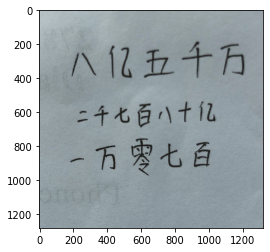

In [2]:
import matplotlib.pyplot as plt
plt.imshow(src_img)

In [3]:
# contr_img, contours, hierarchy = cv2.findContours(contr_retrival, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
contours, _ = cv2.findContours(contr_retrival, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
final_contr = np.zeros((final_thr.shape[0], final_thr.shape[1], 3), dtype=np.uint8)
cv2.drawContours(src_img, contours, -1, (0, 255, 0), 1)

mean_lttr_width = letter_width(contours)
print("\nAverage Width of Each Letter:- ", mean_lttr_width)

# -------------/Letter Width Calculation-------#

# --------------Word Detection-----------------#
x_lines = []

for i in range(len(lines_img)):
    x_lines.append(end_wrd_dtct(lines, i, bin_img, mean_lttr_width))

for i in range(len(x_lines)):
    x_lines[i].append(width)

print(x_lines)
# -------------/Word Detection-----------------#

# -------------Letter Segmentation-------------#

for i in range(len(lines)):
    letter_seg(lines_img, x_lines, i)

# ------------\Letter Segmentation-------------#


# -------------Character segmenting------------#

chr_img = bin_img1.copy()

# contr_img, contours, hierarchy = cv2.findContours(chr_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
contours, _ = cv2.findContours(chr_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
# print(len(contours))
# final_contr = np.zeros((final_thr.shape[0],final_thr.shape[1],3), dtype = np.uint8)
# cv2.drawContours(src_img, contours, -1, (0,255,0), 1)

for cnt in contours:
    if cv2.contourArea(cnt) > 20:
        x, y, w, h = cv2.boundingRect(cnt)
        cv2.rectangle(src_img, (x, y), (x + w, y + h), (0, 255, 0), 2)

# -------------/Character segmenting-----------#


# -------------Displaying Image----------------#

# showimages()

# -------------/Displaying Image---------------#


# -------------Closing Windows-----------------#

# closewindows()


Average Width of Each Letter:-  70.54838709677419
[[357, 1215, 1320], [1061, 1320], [1029, 1320]]


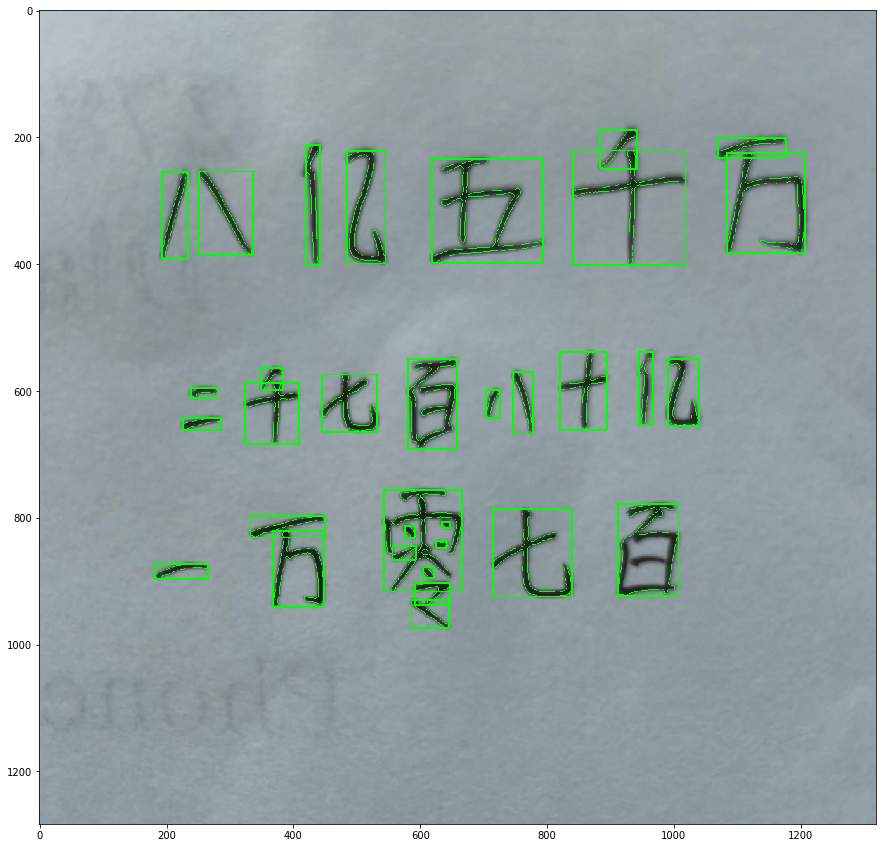

In [6]:
fig = plt.figure(figsize=[15, 15])
plt.imshow(src_img)